In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
image_size = (224, 224)
# batch_size = 8

In [3]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(image_size[0], image_size[1], 3),
)

In [4]:
# Preprocess the input images and apply augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [5]:
base_path = "data/Plant Disease/Plants Disease Dataset Subset" #Local Notebook
source_path = os.path.join(base_path, "Chili")
train_path = os.path.join(source_path, "train")
valid_path = os.path.join(source_path, "valid")

In [23]:
# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=4,
    class_mode='categorical',
    shuffle = False
)

Found 343 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [24]:
for layer in base_model.layers:
    layer.trainable = False

with tf.device("GPU"):
    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(5, activation='softmax'))

# Compile the model
# learning_rate = 0.001
optimizer = Adam(learning_rate=0.004)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
# model.summary()

In [25]:
checkpoint_callback = ModelCheckpoint('./saved_model/chili_model_weights.h5', save_best_only=True, save_weights_only=True)
early_stopping_callback = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_accuracy')

epoch = 22
with tf.device('GPU'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epoch,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]
    )

Epoch 1/22
11/11 [==============================] - 20s 1s/step - loss: 7.2465 - accuracy: 0.2974 - val_loss: 4.3820 - val_accuracy: 0.4600 - lr: 0.0040
Epoch 2/22
11/11 [==============================] - 13s 1s/step - loss: 3.8939 - accuracy: 0.5685 - val_loss: 3.5544 - val_accuracy: 0.5200 - lr: 0.0040
Epoch 3/22
11/11 [==============================] - 12s 1s/step - loss: 3.0228 - accuracy: 0.6910 - val_loss: 2.7675 - val_accuracy: 0.7200 - lr: 0.0040
Epoch 4/22
11/11 [==============================] - 15s 1s/step - loss: 2.4460 - accuracy: 0.7376 - val_loss: 2.1671 - val_accuracy: 0.7400 - lr: 0.0040
Epoch 5/22
11/11 [==============================] - 13s 1s/step - loss: 2.0449 - accuracy: 0.7638 - val_loss: 1.8362 - val_accuracy: 0.7600 - lr: 0.0040
Epoch 6/22
11/11 [==============================] - 10s 943ms/step - loss: 1.6350 - accuracy: 0.7843 - val_loss: 1.6622 - val_accuracy: 0.7400 - lr: 0.0040
Epoch 7/22
11/11 [==============================] - 10s 927ms/step - loss: 1.49

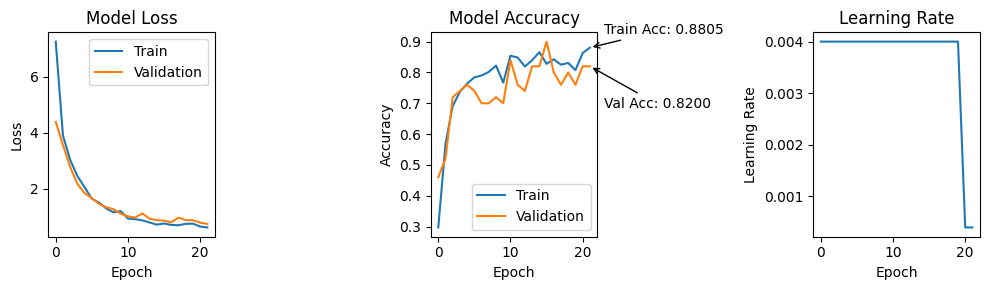

In [26]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(['Train', 'Validation'], loc='upper right')

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Train', 'Validation'], loc='lower right')

axes[2].plot(history.history['lr'])
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')

# Print the final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
axes[1].annotate(f'Train Acc: {final_train_accuracy:.4f}', xy=(len(history.history['accuracy']) - 1, final_train_accuracy), xytext=(10, 10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))
axes[1].annotate(f'Val Acc: {final_val_accuracy:.4f}', xy=(len(history.history['val_accuracy']) - 1, final_val_accuracy), xytext=(10, -30),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()


In [17]:
export_dir = 'saved_model/chili/4'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/chili/4\assets


INFO:tensorflow:Assets written to: saved_model/chili/4\assets


In [18]:
# mode = "Speed" 

# if mode == 'Storage':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
# elif mode == 'Speed':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
# else:
#     optimization = tf.lite.Optimize.DEFAULT

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [19]:
import pathlib
tflite_model_file = pathlib.Path('./assets/chili_disease8882.tflite')
tflite_model_file.write_bytes(tflite_model)

2839536